
## Introduction to Neural Networks

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 9.8
- [astroML website](https://www.astroml.org/index.html)
- [keras Tutorial: Training & evaluation with the built-in methods](https://keras.io/guides/training_with_built_in_methods/)
- [Deep Learning](https://www.deeplearningbook.org/contents/ml.html) by Goodfellow, Bengio, and Courville, Chapter 5 (free to read online!)
- [Introduction to (Deep) Neural Networks](https://github.com/AstroHackWeek/AstroHackWeek2020/blob/master/machinelearning-2/astrohackweek_2020_neural_networks.ipynb) by Kyle Boone @ AstroHackWeek 2020 ([recording](https://www.youtube.com/watch?v=2Lpig1WxadU))

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

![](images/Neuron-image.jpg)

![](images/sinapsis.png)

![](images/Neurons.png)

![](images/brain.gif)

## Neuron pre-activation or input activation


$\Large a(x) = b + \sum_i w_i x_i = b + w^T x$

## Neuron (output) activation

$\Large h(x) = g(a(x)) = g(b + \sum_i w_i x_i)$



* $\Large \bf w$: connection weights
* $\Large b$: neuron bias
* $\Large g(x)$: activation function

Run this cell to confirm you've got `tensorflow` version >2.8.0 (you may have to restart the kernel). 

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.17.0


In [29]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from astroML.datasets import fetch_sdss_specgals, fetch_rrlyrae_combined
from astroML.utils import split_samples

import pandas as pd

from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.neighbors import KNeighborsClassifier

In [30]:
# make the plots look nice
mpl.rcParams['figure.dpi'] = 150
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
cmap = cm.get_cmap('viridis')

/var/folders/_n/wp9xhwf53ds8mr70wtgy43b40000gn/T/ipykernel_33231/2058960318.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


![](images/NN.jpeg)

## What is a neural network?

**Neural networks** are models that are inspired by biological neurons. They are composed of neurons that:
- take in multiple inputs $x_i$
- multiply them by weights $w_i$
- add a bias (in the below diagram, $\theta$)
- apply a non-linear activation function $\varphi$ to give an output activation $o$

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/ArtificialNeuronModel_english.png"> (Chrislb, GFDL)

This activation function can take many forms, like a sigmoid:

<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg">

Neurons are often organized into **layers** which take in the same inputs but apply different weights and biases:

<img src="https://www.astroml.org/_images/fig_neural_network_1.png" />Statistics, Data Mining, and Machine Learning in Astronomy (2020)

If all neurons in a layer are connected to all neurons in the previous layer, then the two layers are **fully connected** and the output of the neurons in the layer can be thought of as a matrix multiplication followed by a non-linear function:
$$ \vec{o} = \varphi(W \vec{x} + \vec{b})$$
The **width** of a layer is the number of neurons it has. A network that as a wide **hidden layer** between the input and output can represent any (well-behaved) function, so neural networks are the ultimate in flexible models (Universal approximation theorem (Hornik, 1991)).

However, instead of using an extremely wide network, the same performance can be obtained by having a sequence of layers that take the previous layer's output as their own input. This strategy tends to use fewer neurons overall. The number of layers is the **depth** of the network, and  having at least two **hidden layers** between the network's input and output makes that network **deep**. In deep neural networks, successive layers tend to learn more complex features about the data, reducing the need for feature engineering:

<img src="https://blogs.nvidia.com/wp-content/uploads/2018/07/hierarchical_features.png"> ([NVIDIA blog](https://blogs.nvidia.com/blog/2018/08/02/supervised-unsupervised-learning/))

## Photometric redshifts with neural nets

`astroML` gives us easy access to a [sample of the SDSS galaxies](https://www.astroml.org/modules/generated/astroML.datasets.fetch_sdss_specgals.html): over 600,000 of them! We have a lot of different measurements for each of them, some of them from imaging, others from spectroscopy. We want to see if we can learn the redshifts using only the colors of the galaxies - photometric redshifts. **why do we want to do that?**

In [31]:
# Fetch and prepare the data
data = fetch_sdss_specgals()
print(data.shape)
print(data.dtype.names)

(661598,)
('ra', 'dec', 'mjd', 'plate', 'fiberID', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID')


### Question: what should we do first?

We are most interested in the (model-fitting) photometry modelMag in *u*, *g*, *r*, *i*, and *z* bands and the spectroscopic redshifts *z*, because we want to construct a model that predicts redshift from photometry. We'll only use 10% of the data to make our neural nets train faster. Let's make another corner plot.

In [32]:
# isolate columns we're interested in
features = ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']
target = 'z'
# reduce data set by 10x for demo purposes
df = pd.DataFrame(data[features + [target]])[::10]

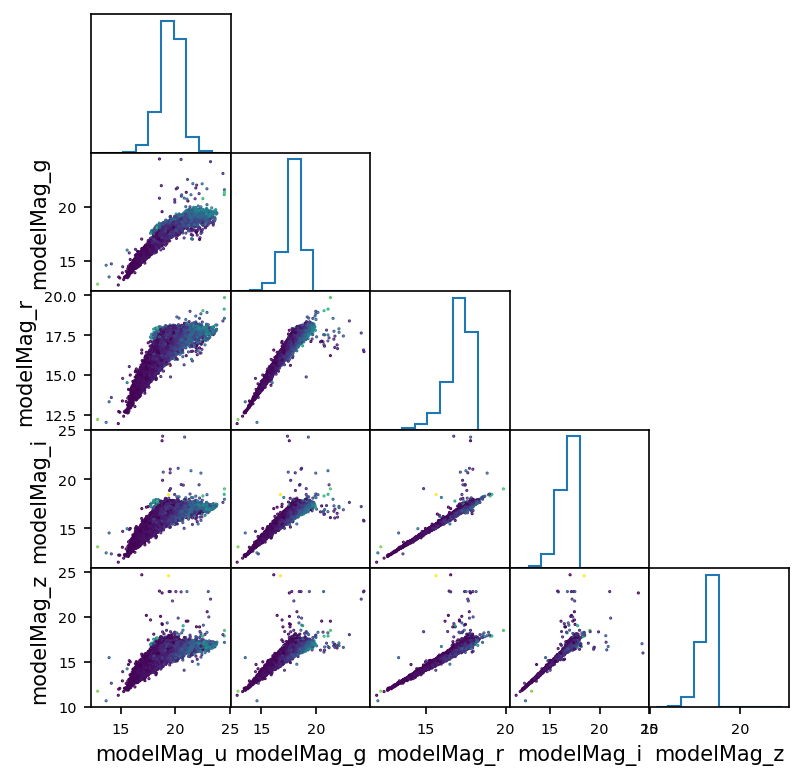

In [33]:
# make a corner plot
fig = plt.figure(figsize=(7.2,7.2))
fig.subplots_adjust(hspace=0, wspace=0)
# loop through every possible pair of features
for i in range(len(features)):
    for j in range(len(features)):
        # only make subplots in the lower diagonal
        if i <= j:
            plt.subplot(6,6,i+j*6+1)
            # if this subplot is on the left side (but not the top), make a y label
            if i == 0 and j != 0:
                plt.ylabel(features[j])
            # if this subplot is on the bottom, make an x label
            if j == 4:
                plt.xlabel(features[i])
            # remove ticks on interior plots
            if i != 0:
                plt.yticks([])
            if j != len(features) - 1:
                plt.xticks([])
            # scatter plots in off diagonals
            if i < j:
                plt.scatter(df[features[i]], df[features[j]], s=1, marker='.', c=df[target], cmap=cmap)
            # histograms on diagonals
            if i == j:
                plt.hist(df[features[i]], histtype='step')
                plt.yticks([]) # don't want counts in the y-axis
plt.show()

While photometry and redshift are definitely related, the relationships seem fairly complicated. We might think about using colors rather than just magnitudes (this would be **feature engineering**), but let's first see how well a neural network can do with the raw magnitudes.

Let's also hold out 10% of the data as a validation set.

In [34]:
# take 10% of the data set as the validation set
valid_df = df.sample(frac=0.1, random_state=1)
# remove the validation set to create the training set
train_df = df.drop(valid_df.index)

### Backpropagation

Let's set up the neural network from the textbook to do regression on the photometric magnitudes to predict redshift. There will be an input layer of 5 neurons for the 5 magnitudes, a hidden layer of four neurons and an output layer of 1 neuron for the predicted redshift. **We won't use an activation function $g$ for the output, since redshift is unbounded and can be negative.** 

**One of the many things Jeff Hinton is known for**

<img src="https://www.astroml.org/_images/fig_neural_network_1.png" />Statistics, Data Mining, and Machine Learning in Astronomy (2020)

Then, the network's predicted redshift for some inputs $x_i$ can be written as:

$$\hat{z} = \sum_{j=1}^4 w_{jk} a_j + b_{k} $$

$$a_j = f\left(\sum_{i=1}^5 w_{ij} x_i + b_j\right) $$


We want to minimize a loss function to encourage the network to make better predictions; for regression, we can use the squared error:
$$ L = \sum_{\ell \in {\rm data}} (z_\ell - \hat{z}_\ell)^2 $$

The network parameters we can change are the weights $w_{ij}$, $w_{jk}$ and biases $b_j$, $b_k$. To change these parameters to minimize the loss function, we need the derivatives of the loss function with respect to the parameters. The derivatives with respect to the output layer aren't bad:

$$ \frac{\partial L}{\partial b_k} = \sum_\ell 2 (z_\ell - \hat{z}_\ell) (-1) $$

$$\frac{\partial L}{\partial w_{jk}} = \sum_\ell 2 (z_\ell - \hat{z}_\ell) (-a_j) $$

To get the derivatives with respect to the hidden layer, we need to apply the chain rule. Doing this computationally efficiently is called **backpropagation**:

$$ \frac{\partial L}{\partial b_j} = \frac{\partial L}{\partial a_j} \frac{\partial a_j}{\partial b_j} = \sum_\ell - 2 (z_\ell - \hat{z}_\ell) w_{jk} \frac{\partial a_j}{\partial b_j}  = - 2 (z_\ell - \hat{z}_\ell) w_{jk} f'\left(\sum_{i=1}^5 w_{ij} x_i + b_j\right) 
$$

$$
\frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial a_j} \frac{\partial a_j}{\partial w_{ij}} = \sum_\ell - 2 (z_\ell - \hat{z}_\ell) w_{jk} \frac{\partial a_j}{\partial w_{ij}}  = - 2 (z_\ell - \hat{z}_\ell) w_{jk} f'\left(\sum_{i=1}^5 w_{ij} x_i + b_j\right) x_i $$

Because derivatives of the activation function, $f'$, pop up often a common choice for the activation function is the recified linear unit (ReLU):
$$f(x) = \begin{cases}
x {\rm \,if\,} x > 0 \\
0 {\rm \,if\,} x \leq 0
\end{cases} $$
It's non-linear (because of its behaviour at $x \leq 0$) but has a very simple derivative:
$$f'(x) = \begin{cases}
1 {\rm \,if\,} x > 0 \\
0 {\rm \,if\,} x < 0
\end{cases} $$

There exist many software packages like `tensorflow`, `keras`, and `pytorch`, that make it easy to create and train neural networks - they'll do the backpropagation automatically, and feed those derivatives into an optimizer to train your network! We'll be using the `keras` package in this notebook.

### Training a neural network in keras

One common trick to getting a neural network to train well is to normalize the data. Neural nets are happy when all of the features are of the 
same scale, and ideally have zero mean and unit standard deviation. We'll use the `keras` `Normalization` object that learns the mean and standard deviation of each feature from the training set, and can be used as the first layer of our neural net.

Tricks like these make machine learning more of an art than an exact science - knowing what to do to make your neural network better can be hard, but evaluating your choice is easy - run on the validation set!

In [114]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(train_df[features].to_numpy()) # only use the training set to normalize!

This next cell of code defines our neural network **architecture**: the inputs (the five photometric magnitudes) are first normalized, and are then followed by a hidden layer of four neurons with ReLU activations, and finally an output layer of one neuron. The activation of this output neuron will be the predicted redshift.

In [130]:
model = keras.Sequential([
    normalizer, # normalizer
    tf.keras.layers.Dense(4, activation='relu'), # hidden layer
    tf.keras.layers.Dense(1, activation='linear') # predicted redshift
    ])

model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_16                │ (None, 4)              │             9 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (40.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9 (40.00 B)

We then tell `keras` that we want to use the RMSprop **optimizer** to minimize our chosen **loss function**, the mean squared error. We can also tell `keras` to report the root mean squared error, since that has units of redshift.

In [131]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.RootMeanSquaredError()],
)

More machine learning tricks! We will use the `ReduceLROnPlateau` **scheduler** that reduces the **learning rate** by a factor of 10 when the validation loss plateaus for 5 **epochs** (run-throughs of the data set). Often, when the loss plateaus, decreasing the learning rate can yield further improvement.

We will also use the `EarlyStopping` callback to stop training if the validation loss plateaus for 10 epochs. Neural networks are very flexible, so this stops training before too much overfitting to the training set happens. An alternative would be to use some sort of [regularization](https://keras.io/api/layers/regularization_layers/) on the network parameters.

In [132]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=0.0001,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    )
]

Finally, we're almost ready to train the neural net! We'll feed in the training data in **minibatches** of 128 and train for a maximum of 100 epochs (runs through the data). The derivatives on the minibatches will, on average, be the same as the derivatives calculated on the entire dataset, but the variability between batches provides stochasticity to help the network get unstuck from local minima. We provide the validation data and link our scheduler and early stopping callbacks so that they have access to the validation data.

In [133]:
history = model.fit(
    train_df[features],
    train_df[target],
    batch_size=128,
    epochs=100,
    validation_data=(valid_df[features], valid_df[target]),
    callbacks=callbacks
)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.1596 - root_mean_squared_error: 0.3921 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1557 - learning_rate: 0.0010
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.0073 - root_mean_squared_error: 0.0848 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695 - learning_rate: 0.0010
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616 - learning_rate: 0.0010
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432 - learning_rate: 0.0010
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344 - learning_rate: 0.0010
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.0021 - roo

All of the choices we made, like:
- number of layers
- activation function
- loss function
- optimizer
- scheduler
- early stopping / regularization
- mini-batch size

are **hyperparameters** - in this context, parameters that must be set before training the neural network. Deciding which hyperparameters to focus on limited computer time is part of the art of machine learning. Often, practitioners will conduct **hyperparameter tuning** to find a set of hyperparameters that does well on the validation set. A good first strategy is **random search** - select sets of hyperparameters at random from a defined space, and see what does the best!

Let's see how well this network does on the validation set. Since we're not training, we don't want `keras` to use CPU time doing backpropagation, so we use the `predict` function:

In [134]:
def plot_redshifts(true_z, pred_z):
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(wspace=0.25,
                        left=0.1, right=0.95,
                        bottom=0.15, top=0.9)

    ax = plt.axes()
    H, zs_bins, zp_bins = np.histogram2d(pred_z, true_z, 151)
    ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
               extent=[zs_bins[0], zs_bins[-1], zp_bins[0], zp_bins[-1]],
               cmap=plt.cm.binary)
    ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
    rms = np.sqrt(np.mean((true_z - pred_z)**2))
    ax.text(0, 0.35, 'RMS error = %0.3f' % rms)
    ax.set_xlim(-0.02, 0.4001)
    ax.set_ylim(-0.02, 0.4001)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.set_xlabel(r'$z_{\rm true}$')
    ax.set_ylabel(r'$z_{\rm fit}$')
    plt.show()

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


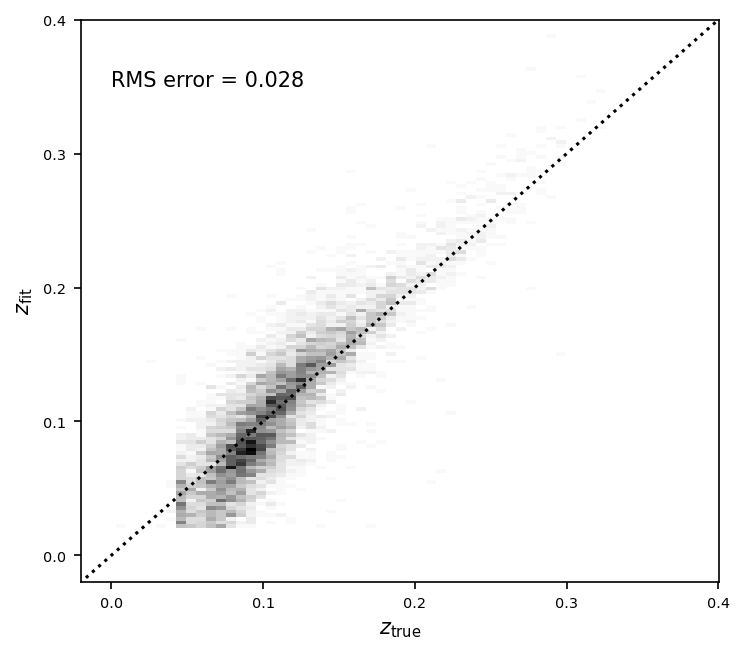

In [135]:
predictions = model.predict(valid_df[features])
plot_redshifts(valid_df[target], predictions.flatten())

### Exercise: Feature engineering
Instead of using the raw magnitudes, will the neural net do better if we provide it photometric colors?

Create a neural network that takes colors and predicts photometric redshifts

In [136]:
# add color columns
df['u-g'] = df['modelMag_u'] - df['modelMag_g']
df['g-r'] = df['modelMag_g'] - df['modelMag_r']
df['r-i'] = df['modelMag_r'] - df['modelMag_i']
df['i-z'] = df['modelMag_i'] - df['modelMag_z']

# take 10% of the data set as the validation set
valid_df = df.sample(frac=0.1, random_state=1)
# remove the validation set to create the training set
train_df = df.drop(valid_df.index)

# now use four colors and r band magnitude
features2 = ['u-g', 'g-r', 'modelMag_r', 'r-i', 'i-z']

In [137]:
train_df[features2].to_numpy()

array([[ 1.6533251 ,  0.82308006, 14.674012  ,  0.43972397,  0.32674408],
       [ 2.2372398 ,  1.0244637 , 17.46213   , -1.929327  ,  2.9880276 ],
       [ 1.4911137 ,  0.7933121 , 16.253967  ,  0.45942688,  0.34089088],
       ...,
       [ 1.3758373 ,  0.7885151 , 16.939415  ,  0.35767555,  0.2927513 ],
       [ 1.723835  ,  0.45661354, 17.655216  ,  0.276165  ,  0.24526405],
       [ 2.4555016 ,  1.068039  , 17.672653  ,  0.48605728,  0.33774185]],
      dtype=float32)

#### your code goes here

In [ ]:
predictions = model2.predict(valid_df[features2])
plot_redshifts(valid_df[target], predictions.flatten())

## RR Lyrae classification with neural nets

Let's quickly revisit the RR Lyrae classification with neural nets.

In [138]:
# fetch the data and print its dimensions
X, y = fetch_rrlyrae_combined()
features = ['u-g', 'g-r', 'r-i', 'i-z']
labels = ['non-variable', 'RR Lyrae']
print('X.shape', X.shape)

# tensor flow wants target as 2D array
y = y.reshape(-1,1)
print('y.shape', y.shape)

# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

X.shape (93141, 4)
y.shape (93141, 1)


It turns out this classification problem is harder, so we'll use a **deep** neural net with two hidden layers. Also, the interpretation of the output neuron will be different: we'll use a *sigmoid* activation function on the output neuron to give a probability $p$ between 0 and 1 that a star is an RR Lyrae. If we use the network as a model for the probability of each data point being an RR Lyrae, the likelihood of observing the training set is:
$$\left(\prod_{i \in {\rm RR\,Lyrae}} p_i\right) \left( \prod_{i \in {\rm not\,variable}} (1-p_i) \right)$$
Taking the negative log likelihood gives us the *binary cross-entropy*, so minimizing this loss function is doing a maximum likelihood fit!

If we wanted to predict $k>2$ classes, we can generalize this formalism and have an output layer with $k$ neurons, and use the *softmax* activation function to yield $k$ class probabilities that add up to 1. The corresponding negative log likelihood would be the *categorical cross-entropy* loss function.
$${\rm softmax}(\{\mathcal{O}_i\}) = \left\{\frac{\exp(\mathcal{O}_i)}{\sum_j \exp(\mathcal{O}_j)}\right\}$$

In [142]:
normalizer = layers.Normalization()
normalizer.adapt(X_train)

model = keras.Sequential([
    normalizer,
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid') # now this is a probability!
    ])

model.compile(
    # Optimizer
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(), # use this loss function for binary classification
    # List of metrics to monitor
    metrics=[keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')],
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=1,
        min_delta=1e-5,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-5,
        patience=20,
        verbose=1,
    )
]

model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=4096,
    epochs=300,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_19                │ (74512, 4)             │             9 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (40.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9 (40.00 B)

Epoch 1/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6456 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5892 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5552 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5151 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5082 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4769 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4705 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4393 - val_precision: 0.0000e+00 - val_recall: 

### Question
I used such large minibatches in training - what property of the dataset would motivate my choice?

292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


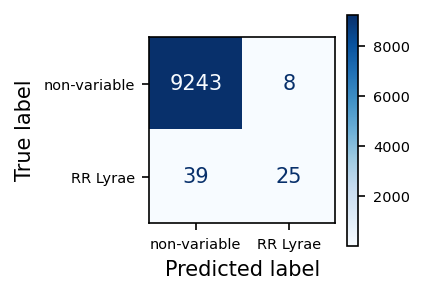

RR Lyrae Recall 0.391
RR Lyrae Precision 0.758


In [143]:
# get predicted probabilities on test set
# convert back to 1D array to make scikit-learn happier
predictions_probability = model.predict(X_test).reshape(-1)
# convert to class prediction with 50% threshold
predictions_class = predictions_probability > 0.5

# plot confusion matrix
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_test, predictions_class, cmap='Blues', display_labels=labels, ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_test, predictions_class))
print('RR Lyrae Precision %0.3f' % precision_score(y_test, predictions_class))

When using neural networks, it's always good to compare to a simpler baseline model to see how much performance your neural network is really giving you. Here I compare the neural net to a $k=5$ nearest neighbors classifier.

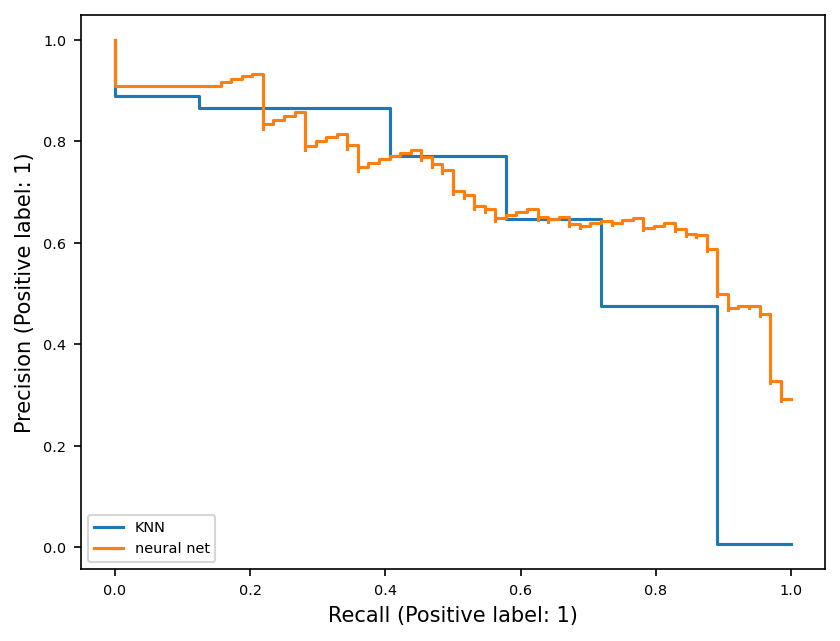

In [145]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train[:,0])

knn_log_proba = knn.predict_proba(X_test)[:, 1]

fig = plt.figure()
ax = fig.add_subplot()

PrecisionRecallDisplay.from_predictions(y_test[:,0], knn_log_proba, label='KNN', ax=ax)
PrecisionRecallDisplay.from_predictions(y_test[:,0], predictions_probability, label='neural net', ax=ax)

plt.show()


### Exercise: Build a model that improves on this classification ####

